In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import rasterio
import numpy as np
from torchvision.io import read_image
from torchvision.transforms import ToTensor, Normalize
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.dataset import Subset
from sklearn.metrics import classification_report
import os
import matplotlib.pyplot as plt
import random
from tqdm import tqdm
tqdm.pandas()

/work/scorreacardo_umass_edu/miniconda3/envs/urbano2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/train"
validation_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/validation"
test_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/test"
test_dir2 = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/random_synthetic"

In [3]:
file_list = sorted([filename for filename in os.listdir(train_dir) if filename.startswith("GSD")], key=lambda x: int(x.split('_')[1][:-2]))
file_list

['GSD_50cm',
 'GSD_65cm',
 'GSD_80cm',
 'GSD_100cm',
 'GSD_124cm',
 'GSD_150cm',
 'GSD_175cm',
 'GSD_200cm',
 'GSD_250cm',
 'GSD_300cm']

In [5]:
test_path = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/train/GSD_300cm"
size = len([f for f in os.listdir(test_path) if f.startswith("row")])
print(f"size of training data for GSD_250cm: {size} chips of 256x256")

size of training data for GSD_250cm: 73306 chips of 256x256


In [2]:
class SensorDataset(Dataset):
    def __init__(self, root_dir, set_type, transform=None, max_black_pixels=0.4, max_white_pixels=0.4):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted([filename for filename in os.listdir(root_dir) if filename.startswith("GSD")], key=lambda x: int(x.split('_')[1][:-2]))
        self.filepaths = []
        self.labels = []
        self.set_type = set_type

        for i, sensor_class in enumerate(self.classes):
            print(sensor_class)
            class_dir = os.path.join(root_dir, sensor_class)
            if self.set_type == 'train':
                file_list = [f for f in os.listdir(class_dir) if f.startswith("row")]
                sampled_files = random.sample(file_list, k=int(len(file_list) * 0.4))
            elif self.set_type == 'syn':
                file_list = [f for f in os.listdir(class_dir) if f.startswith("random")]
                sampled_files = random.sample(file_list, k=int(len(file_list) * 1))
                print(len(sampled_files))
            else:
                file_list = [f for f in os.listdir(class_dir) if f.startswith("row")]
                sampled_files = random.sample(file_list, k=int(len(file_list) * 0.1))
                
            for filename in sampled_files:
                filepath = os.path.join(class_dir, filename)
                self.filepaths.append(filepath)
                self.labels.append(i)
            print(i)
                
        # Prune the dataset based on black and white pixel percentages
        self.prune_dataset(max_black_pixels, max_white_pixels)

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, index):
        filepath = self.filepaths[index]
        label = self.labels[index]

        with rasterio.open(filepath, 'r') as img:
            image = img.read().transpose(1, 2, 0)

        if self.transform:
            image = self.transform(image).float()
            #print(f" in transform: {image.shape}")

        return image, label
    
    def prune_dataset(self, max_black_pixels, max_white_pixels):
        pruned_filepaths = []
        pruned_labels = []
        channels_sum = np.zeros((3,))
        channels_squared_sum = np.zeros((3,))

        for filepath, label in zip(self.filepaths, self.labels):
            with rasterio.open(filepath, 'r') as img:
                image = img.read().transpose(1, 2, 0)  # Transpose to (H, W, C) (512,512,3)

            # Calculate the percentage of black and white pixels
            total_pixels = np.prod(image.shape)
            black_pixels = np.sum(image == 0)
            white_pixels = np.sum(image == 255)
            black_pixel_percentage = black_pixels / total_pixels
            white_pixel_percentage = white_pixels / total_pixels

            # Prune the image if it falls outside the specified range
            if black_pixel_percentage <= max_black_pixels and white_pixel_percentage <= max_white_pixels:
                pruned_filepaths.append(filepath)
                pruned_labels.append(label)
                
                channels_sum += np.sum(image, axis=(0, 1))
                channels_squared_sum += np.sum(np.square(image), axis=(0, 1))
                

        self.filepaths = pruned_filepaths
        self.labels = pruned_labels
        num_samples = len(self.filepaths)
        self.mean = channels_sum / (num_samples * image.shape[0] * image.shape[1])
        variance = (channels_squared_sum / (num_samples * image.shape[0] * image.shape[1])) - np.square(self.mean)
        variance = np.maximum(variance, 1e-8)  # Clip variance to a minimum value of epsilon
        self.std = np.sqrt(variance)
        
        self.mean = self.mean.tolist()
        self.std = self.std.tolist()

In [37]:
# Set the directory paths for train, validation, and test
train_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/train"
validation_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/validation"
test_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/test"

# Define the image transformation
image_transform = ToTensor()  # Add other transformations as needed

# # Create the datasets
train_dataset = SensorDataset(train_dir, transform=image_transform)
validation_dataset = SensorDataset(validation_dir, transform=image_transform)
test_dataset = SensorDataset(test_dir, transform=image_transform)

# # Create the data loaders for batching and shuffling
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

5863it [01:18, 74.47it/s]


In [38]:
 #
  # True standard deviation
  #
mean = 0.0
meansq = 0.0
count = 0
import pdb
for index, data in tqdm(enumerate(train_loader)):
    #pdb.set_trace()
    batch_size = data[0].shape[0]
    data_batch = data[0]  # Concatenate tensors from the list
    mean += data_batch.sum(dim=(0, 2, 3))
    meansq += (data_batch **2).sum(dim=(0, 2, 3))
    count += batch_size * data_batch .shape[2] * data_batch.shape[3]

total_mean = mean / count
total_var = (meansq / count) - (total_mean**2)
total_std = torch.sqrt(total_var)
print("mean: " + str(total_mean.tolist()))
print("std: " + str(total_std.tolist()))

232it [00:13, 17.19it/s]

mean: [0.46619912981987, 0.4138015806674957, 0.2945951819419861]
std: [0.19115719199180603, 0.1479424238204956, 0.13974712789058685]


### Let's start the training

In [3]:
# Set the device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Set the training parameters
batch_size = 16 
num_epochs = 40
learning_rate = 1e-4

# Set the path to your train, validation, and test directories
train_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/train"
validation_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/validation"
test_dir = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/test"
test_dir2 = "/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/random_synthetic"

# Define the image transformations
transform = torchvision.transforms.Compose([
    ToTensor(),
    Normalize([0.46619912981987, 0.4138015806674957, 0.2945951819419861], 
              [0.19115719199180603, 0.1479424238204956, 0.13974712789058685])  # Normalize image tensors
])

# Create custom datasets
train_dataset = SensorDataset(train_dir, 'train', transform=transform)
validation_dataset = SensorDataset(validation_dir, 'val', transform=transform)
test_dataset = SensorDataset(test_dir2, 'syn', transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

GSD_50cm
0
GSD_65cm
1
GSD_80cm
2
GSD_100cm
3
GSD_124cm
4
GSD_150cm
5
GSD_175cm
6
GSD_200cm
7
GSD_250cm
8
GSD_300cm
9
GSD_50cm
0
GSD_65cm
1
GSD_80cm
2
GSD_100cm
3
GSD_124cm
4
GSD_150cm
5
GSD_175cm
6
GSD_200cm
7
GSD_250cm
8
GSD_300cm
9
GSD_50cm
1846
0
GSD_65cm
621
1
GSD_80cm
936
2
GSD_100cm
991
3
GSD_124cm
641
4
GSD_150cm
1055
5
GSD_175cm
1109
6
GSD_200cm
2594
7
GSD_250cm
2078
8
GSD_300cm
1601
9


/work/scorreacardo_umass_edu/miniconda3/envs/urbano2/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [8]:
# Load the pre-trained ResNet model
model = torchvision.models.resnet18(pretrained=True)
num_classes = len(train_dataset.classes)

# Modify the last fully connected layer to match the number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move the model to the device
model = model.to(device)

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

learning_courve = []
# Training loop
for epoch in range(num_epochs):
    model.train()  # Set the model to training mode

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print the loss every 10 iterations
        if (i + 1) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Iteration [{i+1}/{len(train_loader)}], Loss: {loss.item()}")
            learning_courve.append([epoch+1, loss.item()])
    # Print the training loss for each epoch
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}")
    learning_courve.append([epoch+1, loss.item()])

Epoch [1/3], Iteration [100/9185], Loss: 0.5580797791481018
Epoch [1/3], Iteration [200/9185], Loss: 0.5968358516693115
Epoch [1/3], Iteration [300/9185], Loss: 0.8859381675720215
Epoch [1/3], Iteration [400/9185], Loss: 0.21889206767082214
Epoch [1/3], Iteration [500/9185], Loss: 0.24424295127391815
Epoch [1/3], Iteration [600/9185], Loss: 0.38198068737983704
Epoch [1/3], Iteration [700/9185], Loss: 0.22191312909126282
Epoch [1/3], Iteration [800/9185], Loss: 0.3493388891220093
Epoch [1/3], Iteration [900/9185], Loss: 0.40087369084358215
Epoch [1/3], Iteration [1000/9185], Loss: 0.28318431973457336
Epoch [1/3], Iteration [1100/9185], Loss: 0.5532875657081604
Epoch [1/3], Iteration [1200/9185], Loss: 0.2062426060438156
Epoch [1/3], Iteration [1300/9185], Loss: 0.3600768744945526
Epoch [1/3], Iteration [1400/9185], Loss: 0.08528557419776917
Epoch [1/3], Iteration [1500/9185], Loss: 0.2478795200586319
Epoch [1/3], Iteration [1600/9185], Loss: 0.5502135753631592
Epoch [1/3], Iteration [17

In [ ]:
import matplotlib.pyplot as plt


plt.plot(learning_courve, marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

In [ ]:
test_dir2 = '/work/scorreacardo_umass_edu/DeepSatGSD/data/processed/random_synthetic'
test_dataset = SensorDataset(test_dir2, 'syn', transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Evaluation on validation set
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in validation_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

validation_accuracy = total_correct / total_samples
print(f"Validation Accuracy: {validation_accuracy}")

# Compute additional performance metrics
classification_metrics = classification_report(true_labels, predicted_labels, target_names=validation_dataset.classes)
print("Classification Report:")
print(classification_metrics)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Compute the row sums
row_sums = confusion_mat.sum(axis=1, keepdims=True)

# Divide each element of the confusion matrix by its corresponding row sum
confusion_mat_percent = confusion_mat / row_sums

# Plot the confusion matrix using seaborn
class_names = train_dataset.classes  # Assuming you have access to the class names
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat_percent, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()

In [9]:
# Evaluation on test set
model.eval()  # Set the model to evaluation mode
total_correct = 0
total_samples = 0
predicted_labels = []
true_labels = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        total_samples += labels.size(0)
        total_correct += (predicted == labels).sum().item()

        predicted_labels.extend(predicted.tolist())
        true_labels.extend(labels.tolist())

test_accuracy = total_correct / total_samples
print(f"Test Accuracy: {test_accuracy}")

# Compute additional performance metrics
classification_metrics = classification_report(true_labels, predicted_labels, target_names=test_dataset.classes)
print("Classification Report:")
print(classification_metrics)

100%|██████████| 544/544 [08:53<00:00,  1.02it/s]

Test Accuracy: 0.7128393925448688
Classification Report:
              precision    recall  f1-score   support

    GSD_50cm       0.55      0.19      0.28      1138
    GSD_65cm       0.72      0.91      0.81       475
    GSD_80cm       0.34      0.83      0.49       605
   GSD_100cm       0.66      0.99      0.79       686
   GSD_124cm       0.85      0.07      0.13       335
   GSD_150cm       0.99      0.33      0.49       730
   GSD_175cm       0.55      0.97      0.71       542
   GSD_200cm       1.00      1.00      1.00      1728
   GSD_250cm       1.00      0.56      0.72      1370
   GSD_300cm       0.73      1.00      0.84      1083

    accuracy                           0.71      8692
   macro avg       0.74      0.69      0.63      8692
weighted avg       0.78      0.71      0.68      8692



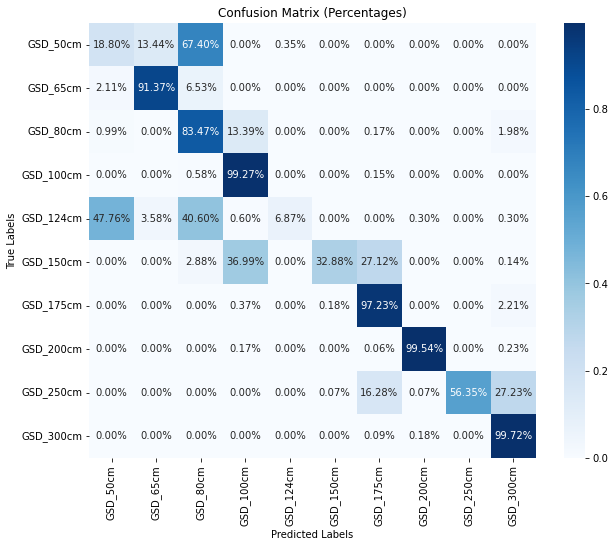

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Compute the confusion matrix
confusion_mat = confusion_matrix(true_labels, predicted_labels)

# Compute the row sums
row_sums = confusion_mat.sum(axis=1, keepdims=True)

# Divide each element of the confusion matrix by its corresponding row sum
confusion_mat_percent = confusion_mat / row_sums

# Plot the confusion matrix using seaborn
class_names = train_dataset.classes  # Assuming you have access to the class names
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mat_percent, annot=True, fmt=".2%", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix (Percentages)")
plt.show()

In [13]:
# After training loop
# Save the model
torch.save(model.state_dict(), '/work/scorreacardo_umass_edu/DeepSatGSD/models/trained_model_gsd_resnet18_epochs_3_training_40_perc.pt')
print("Model saved successfully.")

Model saved successfully.
